## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [46]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [47]:
df.corr()

,patient_id,global_num,birth_year,infection_order,infected_by,contact_number
patient_id,1.000000,-0.144366,-0.058170,-0.203748,0.911091,-0.128676
global_num,-0.144366,1.000000,0.017849,0.685239,-0.050353,-0.122026
birth_year,-0.058170,0.017849,1.000000,-0.510739,0.069607,0.003549
infection_order,-0.203748,0.685239,-0.510739,1.000000,-0.547866,0.008365
infected_by,0.911091,-0.050353,0.069607,-0.547866,1.000000,-0.136611
contact_number,-0.128676,-0.122026,0.003549,0.008365,-0.136611,1.000000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

<AxesSubplot:>

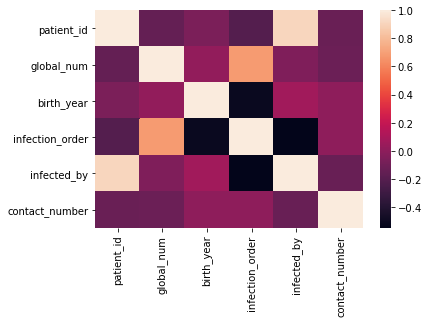

In [49]:
sns.heatmap(df.corr())

In [50]:
df.shape

(2218, 18)

In [51]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


Remove date columns from the data.


In [52]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [53]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [54]:
def age(birthdate):
    from datetime import date
   
    today = date.today()
    # im not even using this bd line. 
    bd = pd.to_datetime(birthdate, format='%Y')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

df['bd'] = pd.to_datetime(df.birth_year, format='%Y')

df['n_age'] = df['bd'].apply(lambda x: age(x))

df['n_age'].value_counts()

52.0     54
26.0     51
23.0     47
22.0     45
25.0     45
         ..
95.0      2
2.0       2
96.0      1
105.0     1
90.0      1
Name: n_age, Length: 96, dtype: int64

In [55]:
# np.unique(df.n_age, return_counts=True)

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [56]:
nulls = pd.DataFrame(df.isnull().sum())
nulls.T

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,bd,n_age
0,0,904,145,454,261,0,0,65,2199,1055,2176,1749,1807,88,454,454


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       2218 non-null   int64         
 1   global_num       1314 non-null   float64       
 2   sex              2073 non-null   object        
 3   birth_year       1764 non-null   float64       
 4   age              1957 non-null   object        
 5   country          2218 non-null   object        
 6   province         2218 non-null   object        
 7   city             2153 non-null   object        
 8   disease          19 non-null     object        
 9   infection_case   1163 non-null   object        
 10  infection_order  42 non-null     float64       
 11  infected_by      469 non-null    float64       
 12  contact_number   411 non-null    float64       
 13  state            2130 non-null   object        
 14  bd               1764 non-null   datetim

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [58]:
## why keep a column with 1 % values in it ? 
df.disease.value_counts()

True    19
Name: disease, dtype: int64

In [59]:
df.disease.fillna(0,inplace=True)
df.disease = (df.disease == True).astype(int)
np.unique(df.disease, return_counts = True)

(array([0, 1]), array([2199,   19]))

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [60]:
df['global_num'].fillna(df['global_num'].mean(), inplace=True)

df['n_age'].fillna(df['n_age'].mean(), inplace=True)

df['birth_year'].fillna(df['birth_year'].mean(), inplace=True)


df['infection_order'].fillna(df['infection_order'].mean(), inplace=True)


df['infected_by'].fillna(df['infected_by'].mean(), inplace=True)
df['contact_number'].fillna(df[ 'contact_number'].mean(), inplace=True)

In [61]:
df.contact_number.value_counts()

24.128954     1807
0.000000        47
2.000000        44
3.000000        42
1.000000        34
              ... 
485.000000       1
68.000000        1
64.000000        1
20.000000        1
49.000000        1
Name: contact_number, Length: 73, dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [62]:
df.drop('bd', axis=1,inplace=True)

In [63]:
df.isnull().sum().sort_values(ascending=False)

infection_case     1055
age                 261
sex                 145
state                88
city                 65
patient_id            0
global_num            0
birth_year            0
country               0
province              0
disease               0
infection_order       0
infected_by           0
contact_number        0
n_age                 0
dtype: int64

In [64]:
df.city.value_counts(normalize=True)

Gyeongsan-si     0.248490
Cheonan-si       0.045518
Seongnam-si      0.041338
Bonghwa-gun      0.027868
Gumi-si          0.027404
                   ...   
Anseong-si       0.000464
Yeongyang-gun    0.000464
Gyeryong-si      0.000464
Yeosu-si         0.000464
Danyang-gun      0.000464
Name: city, Length: 134, dtype: float64

In [65]:
df.city.fillna('Gyeongsan-si',inplace=True)

In [66]:
df.sex.value_counts(normalize=True)

female    0.564882
male      0.435118
Name: sex, dtype: float64

In [67]:
df.sex.fillna('male',inplace=True)

In [68]:
df.state.value_counts(normalize=True)

isolated    0.840845
released    0.144131
deceased    0.015023
Name: state, dtype: float64

In [69]:
snull = pd.DataFrame(df[df['state'].isnull()])
snull['province'].value_counts()

Gyeonggi-do         87
Gyeongsangnam-do     1
Name: province, dtype: int64

In [80]:
drops = df[df['state'].isnull()].index
drops

Int64Index([ 802,  803,  804,  805,  806,  807,  808,  809,  810,  811,  812,
             813,  814,  815,  816,  817,  818,  819,  820,  821,  822,  823,
             824,  825,  826,  827,  828,  829,  830,  831,  832,  833,  834,
             835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  845,
             846,  847,  848,  849,  850,  851,  852,  853,  854,  855,  856,
             857,  858,  859,  860,  861,  862,  863,  864,  865,  866,  867,
             868,  869,  870,  871,  872,  873,  874,  875,  876,  877,  878,
             879,  880,  881,  882,  883,  884,  885,  886,  887,  888, 2213],
           dtype='int64')

In [81]:
len(drops)

88

In [83]:
df.drop(drops,inplace=True)

In [84]:
df.province.value_counts()

Gyeongsangbuk-do     1054
Seoul                 282
Gyeonggi-do           213
Chungcheongnam-do     118
Busan                 101
Gyeongsangnam-do       84
Daegu                  63
Sejong                 41
Incheon                32
Ulsan                  30
Gangwon-do             29
Chungcheongbuk-do      28
Daejeon                22
Gwangju                18
Jeollabuk-do            7
Jeollanam-do            4
Jeju-do                 4
Name: province, dtype: int64

In [ ]:
## most nulls for state all in one province, probably drop this as 81/300 total from that area to all be pushed to 
# quarentined seems flawed 

 **<font color='teal'> Check for any remaining null values.</font>**

In [88]:
df.isnull().sum().sort_values(ascending=False)

infection_case     1054
patient_id            0
global_num            0
sex                   0
birth_year            0
country               0
province              0
city                  0
disease               0
infection_order       0
infected_by           0
contact_number        0
state                 0
n_age                 0
dtype: int64

In [87]:
df.drop('age',axis=1,inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2130 non-null   int64  
 1   global_num       2130 non-null   float64
 2   sex              2130 non-null   object 
 3   birth_year       2130 non-null   float64
 4   country          2130 non-null   object 
 5   province         2130 non-null   object 
 6   city             2130 non-null   object 
 7   disease          2130 non-null   int64  
 8   infection_case   1076 non-null   object 
 9   infection_order  2130 non-null   float64
 10  infected_by      2130 non-null   float64
 11  contact_number   2130 non-null   float64
 12  state            2130 non-null   object 
 13  n_age            2130 non-null   float64
dtypes: float64(6), int64(2), object(6)
memory usage: 249.6+ KB


<AxesSubplot:>

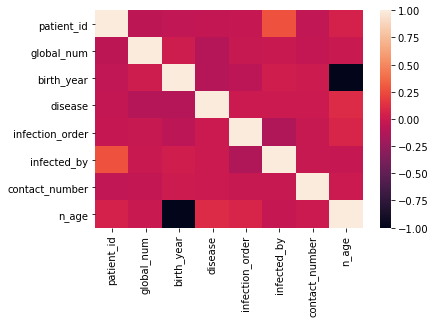

In [90]:
sns.heatmap(df.corr())

In [108]:
df.drop('birth_year',axis=1,inplace=True)

Review the count of unique values by column.

In [109]:
print(dfc.nunique())

patient_id         1076
global_num          630
sex                   2
birth_year           87
country               3
province             17
city                119
disease               2
infection_case       16
infection_order       7
infected_by         196
contact_number       72
state                 3
n_age                87
dtype: int64


Review the percent of unique values by column.

In [110]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.574648
sex                0.000939
country            0.001878
province           0.007981
city               0.062441
disease            0.000939
infection_case     0.007512
infection_order    0.003286
infected_by        0.092019
contact_number     0.034272
state              0.001408
n_age              0.045540
dtype: float64


Review the range of values per column.

In [111]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2130.0,4.095989e+09,2.197921e+09,1.000000e+09,1.600000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2130.0,4.526482e+03,2.137668e+03,1.000000e+00,4.051250e+03,4.664817e+03,5.445500e+03,8.717000e+03
disease,2130.0,8.920188e-03,9.404664e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2130.0,2.285714e+00,1.741536e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2130.0,2.620626e+09,7.269510e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2130.0,2.414551e+01,3.996888e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2130.0,4.606298e+01,1.728607e+01,1.000000e+00,3.300000e+01,4.601134e+01,5.600000e+01,1.050000e+02


### Check for duplicated rows

In [112]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [113]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,133
4,infection_case,16
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<AxesSubplot:>

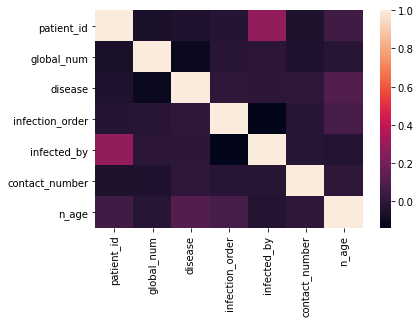

In [114]:
sns.heatmap(df.corr())

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

<AxesSubplot:xlabel='state', ylabel='n_age'>

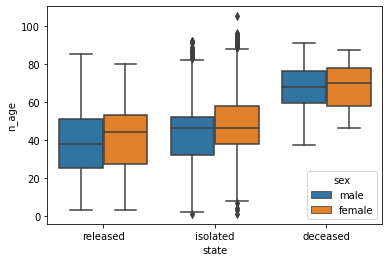

In [117]:
sns.boxplot(x='state',y='n_age',hue='sex',data=df)

<AxesSubplot:xlabel='province', ylabel='n_age'>

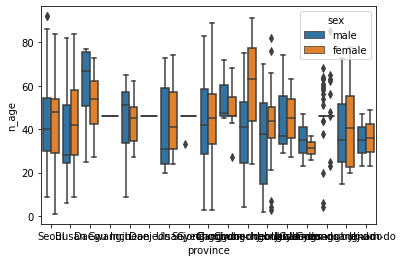

In [118]:
sns.boxplot(x='province',y='n_age',hue='sex',data=dfc)

**<font color='teal'> Create dummy features for object type features. </font>**

In [119]:
dfd = df.drop('state',axis=1)

df_dummies = pd.get_dummies(dfd,drop_first=True)
dfd.columns

Index(['patient_id', 'global_num', 'sex', 'country', 'province', 'city',
       'disease', 'infection_case', 'infection_order', 'infected_by',
       'contact_number', 'n_age'],
      dtype='object')

In [120]:
df_dummies.columns

Index(['patient_id', 'global_num', 'disease', 'infection_order', 'infected_by',
       'contact_number', 'n_age', 'sex_male', 'country_Korea',
       'country_Mongolia',
       ...
       'infection_case_Pilgrimage to Israel',
       'infection_case_River of Grace Community Church',
       'infection_case_Seongdong-gu APT', 'infection_case_Shincheonji Church',
       'infection_case_Suyeong-gu Kindergarten',
       'infection_case_contact with patient', 'infection_case_etc',
       'infection_case_gym facility in Cheonan',
       'infection_case_gym facility in Sejong',
       'infection_case_overseas inflow'],
      dtype='object', length=174)

### Split the data into test and train subsamples

In [121]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = df_dummies
y = df['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [122]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [123]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [124]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.876
Random Forest: f1-score=0.860


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [125]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0]
 [  0 351  14]
 [  0  38  16]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.   0.96 0.04]
 [0.   0.7  0.3 ]]


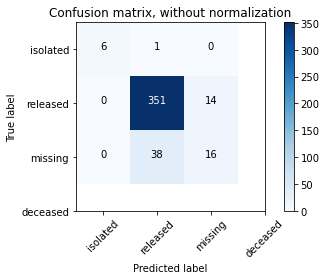

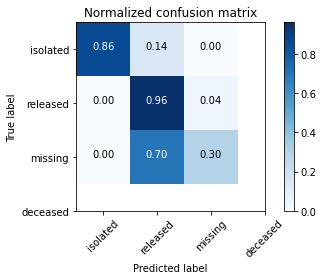

In [127]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


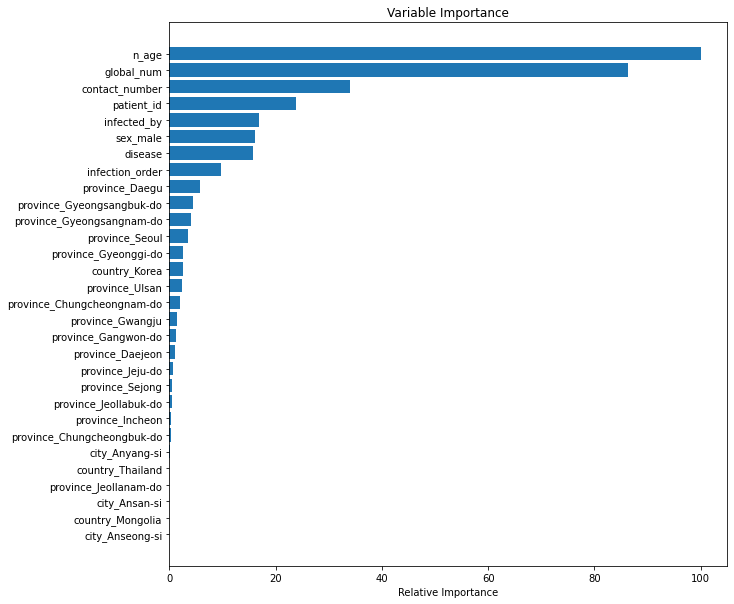

In [128]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.